# Linear classifier with softmax
We continue from the previous notebook [linear classifier with svm](https://minh84.github.io/ml-examples/demos/learn_tf/01-linear-classifier-svm/), in this note book we consider a different loss function the Softmax function
$$
L(y, s(x)) = -\log\left(\frac{e^{s_y(x)}}{\sum_je^{s_j(x)}}\right)
$$
we recall some notation 
$\newcommand{\real}{\mathbb{R}}
\newcommand{\vi}[1]{#1^{(i)}}
\newcommand{\vik}[1]{#1^{(i)}_k}
\newcommand{\vij}[2]{#1^{(i)}_{#2}}
$

* $x\in\real^{D\times 1}$ is input features 
* $s(x)$ is linear score of given by
$$
s(x) = W^T\times x
$$
with $W\in \real^{C\times D}$ with $C$ is number of classes.
``
To make it easier to understand, let's look at an example (taken from [cs231n](http://cs231n.stanford.edu/syllabus.html))
$$
s=\left(\begin{array}{c}
3.2\\
5.1\\
-1.7
\end{array}
\right)=> \exp(s) = \left(\begin{array}{c}
24.5\\
164.0\\
0.18
\end{array}
\right)
$$
then for $y=1$ (here we use convention that array index start from 1) we have then
$$
L(y,s)=-\log\left(\frac{24.5}{24.5 + 164.0 + 0.18}\right) = 0.89
$$

Look at the form of Softmax loss, similar to SVM loss, it also try to increase the chance that $s_y(x)$ is the biggest of $s_j(x)$. Moreover, the Softmax loss is smoother than SVM which in practice will be easier to be optimized.

Now let's derived vector form for Softmax loss & gradient.

## Softmax loss and gradient
We recall that the loss for $N$ samples is given by
$$
\frac{1}{N} \sum_{i=1}^{N}L(\vi{y}, s(\vi{x})) + \lambda ||W||^2
$$
Recall from previous notebook, we feed data in the following form
$$
X = \left(\begin{array}{c}
(x^{(1)})^T\\
\vdots\\
(x^{(N)})^T
\end{array}\right)\in \mathbb{R}^{N\times D}
$$
denote $S$ is the score matrix given by
$$
S = X \times W
$$
and $ES=\exp\left(S\right)$ $ESN$ is row-sum of $ES$ 
$$
ESN(i) = \sum_{j=1}^{C} ES_{i,j}
$$
then our loss function given by
$$
\mathrm{softmax}\left(W\right)=\frac{1}{N}\sum_{i=1}^N -\log\left(\frac{ES_{i,\vi{y}}}{ESN(i)}\right) + \lambda ||W||^2
$$
Now we need to compute the gradient of above loss with respect to $W$, first let's compute the gradient for one sample $\vi{x},\vi{y}$, we have
$$
\vi{s}=s\left(\vi{x}\right) = W^T\times \vi{x} \Rightarrow \vij{s}{j} = \sum_{k=1}^D\vik{x}W_{kj}
$$
which implies
$$
\frac{\partial}{\partial W_{uv}} \vij{s}{j} = \vij{x}{u} \times 1_{v=j}
$$
so
\begin{align*}
\frac{\partial}{\partial W_{uv}} \left(-\log \frac{\exp\left(\vij{s}{\vi{y}}\right)}{\sum_j\exp\left(\vij{s}{j}\right)}\right)&=  \frac{\partial}{\partial W_{uv}} \log\left(\sum_j\exp\left(\vij{s}{j}\right) \right) - \frac{\partial}{\partial W_{uv}}\vij{s}{\vi{y}} \\
&= \frac{\exp\left(\vij{s}{j}\right)}{\sum_j\exp\left(\vij{s}{j}\right)}\vij{x}{u} -  \vij{x}{u} \times 1_{v=\vi{y}}\\
&= \left(\frac{\exp\left(\vij{s}{j}\right)}{\sum_j\exp\left(\vij{s}{j}\right)} - 1_{v=\vi{y}}\right) \vij{x}{u}
\end{align*} 
Denote $P=(P_{iv})\in \real^{N\times C}$ such that
$$
P_{iv} = \left(\frac{\exp\left(\vij{s}{j}\right)}{\sum_j\exp\left(\vij{s}{j}\right)} - 1_{v=\vi{y}}\right)
$$
Then we have
$$
\nabla_W L(\vi{y},s(\vi{x})) = \vi{x} \times P[i]
$$
where $P[i]$ is $i-$th row of $P$. Taking the sum over $i$ we have
$$
\nabla_W \mathrm{softmax}\left(W\right) = \frac{1}{N} \sum_{i}\vi{x} \times P[i] + \lambda W = \frac{1}{N}X^T\times P + \lambda W
$$

Let's implement Softmax Loss


## Softmax with implementation in Numpy
Numpy is very convenient to do 
* [index accessing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)
* [boardcast operation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# append common path
import sys
COMMON_PATH = '../common'
if COMMON_PATH not in sys.path:
    sys.path.insert(0, COMMON_PATH)
    
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# loading pre-process data
from cifar10_input import load_flatten_CIFAR10
cifar10_dir = 'cifar-10-batches-py'

data = load_flatten_CIFAR10(cifar10_dir)
X_train = data['X_train']
y_train = data['y_train']
mean_images = data['mean_images']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [2]:
def softmax_np(W, X, y, reg):
    N = X.shape[0]
    scores = X.dot(W)
    
    if y is None:
        return scores
    
    # sub max to ensure stable computation
    exp_scores = np.exp(scores - np.amax(scores, axis=1, keepdims=True))
    # normalize exp_scores
    exp_scores /= np.sum(exp_scores, axis=1, keepdims=True)
    
    loss = - np.mean(np.log(exp_scores[range(N), y])) + 0.5 * reg * np.sum(W**2)
    
    # compute P matrix
    exp_scores[range(N), y] -= 1.0
    
    # compute gradient dW
    dW = np.dot(X.T, exp_scores) / N + reg * W
    return loss, dW

### Test the implementation
It's always a good idea to test our implementation v.s numerical gradient

In [3]:
X_dev = X_train[:100]
y_dev = y_train[:100]

D = X_train.shape[1]
C = 10


loss, grad = softmax_np(1e-4 * np.random.randn(D, C), X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss:         {:<10.5f}'.format(loss))
print ('sanity check: {:<10.5f}\n'.format(-np.log(0.1)))

# Generate a random softmax weight matrix and use it to compute the loss.
initW = 0.001 * np.random.randn(D, C) 


loss:         2.39226   
sanity check: 2.30259   



In [4]:
loss_np1, grad_np1 = softmax_np(initW, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse, rel_error

f = lambda w: softmax_np(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, initW, grad_np1, 10)

# similar to SVM case, do another gradient check with regularization
loss_np2, grad_np2 = softmax_np(initW, X_dev, y_dev, 1e2)
f = lambda w: softmax_np(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, initW, grad_np2, 10)

numerical:       0.48 analytic:       0.48, relative error: 4.77513e-08
numerical:       0.10 analytic:       0.10, relative error: 7.90991e-08
numerical:       2.10 analytic:       2.10, relative error: 7.64809e-09
numerical:      -2.83 analytic:      -2.83, relative error: 2.38165e-09
numerical:       0.01 analytic:       0.01, relative error: 3.77501e-08
numerical:      -0.50 analytic:      -0.50, relative error: 3.07524e-08
numerical:      -3.99 analytic:      -3.99, relative error: 4.71411e-13
numerical:      -2.41 analytic:      -2.41, relative error: 1.93992e-09
numerical:       3.88 analytic:       3.88, relative error: 3.21670e-09
numerical:      -1.17 analytic:      -1.17, relative error: 5.49690e-08
numerical:      -3.21 analytic:      -3.21, relative error: 3.81690e-09
numerical:       0.02 analytic:       0.02, relative error: 1.44000e-06
numerical:      -2.32 analytic:      -2.32, relative error: 1.21546e-08
numerical:      -5.65 analytic:      -5.65, relative error: 2.81

The results look correct, let's try it with TensorFlow
## Softmax with TensorFlow
Fortunately, TensorFlow has already implemented Softmax, let's try it out using double precision so that we can compare against Numpy's implementation

In [5]:
tf.reset_default_graph()

# create trainable variable
vW = tf.Variable(initW, dtype=tf.float64, name = 'W')

# create placeholder to feed input
vX = tf.placeholder(tf.float64, name = 'X')
vy = tf.placeholder(tf.int64, name = 'y')
vreg = tf.placeholder(tf.float64, name = 'reg')

# create scores/cost
scores_tf = tf.matmul(vX, vW)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=vy, logits=scores_tf)) + vreg * tf.nn.l2_loss(vW)
grad = tf.gradients(cost, vW)[0]

with tf.Session() as sess:
    # initilized variable
    sess.run(tf.global_variables_initializer())
    
    # compute loss with reg = 0
    loss_tf1, dW_tf1 = sess.run([cost, grad], feed_dict = {vX : X_dev, vy: y_dev, vreg : 0.0})
    print ('reg 0.0')
    print ('loss:         {:<10.5f}\nrel-error     {:<10.5e}'.format(loss_tf1, rel_error(loss_tf1, loss_np1))) 
    
    print ('dW rel-error: {:<10.5e}\n'.format(rel_error(dW_tf1, grad_np1)))
    # compute loss with reg = 100.0
    loss_tf2, dW_tf2 = sess.run([cost, grad], feed_dict = {vX : X_dev, vy: y_dev, vreg : 100.0})
    
    print ('reg 100.0')
    print ('loss:         {:<10.5f}\nrel-error     {:<10.5e}'.format(loss_tf2, rel_error(loss_tf2, loss_np2))) 
    print ('dW rel-error: {:<10.5e}'.format(rel_error(dW_tf2, grad_np2)))

reg 0.0
loss:         4.99920   
rel-error     0.00000e+00
dW rel-error: 5.58395e-12

reg 100.0
loss:         6.53334   
rel-error     2.71891e-16
dW rel-error: 6.22104e-11


The result obtain by Numpy and TensorFlow are similar, let's train our model with SGD.

## Train our model with SGD
We re-use the code implemented from previous notebook

### SGD with softmax_np

In [6]:
from data_utils import Dataset
from func_opt import sgd_np

batch_size = 200
# create data train/val/test
train_data = Dataset(X_train, y_train, batch_size, dtype = np.float32)
val_data = Dataset(X_val, y_val, X_val.shape[0], dtype = np.float32)
test_data = Dataset(X_test, y_test, X_test.shape[0], dtype = np.float32)

lr = 1e-7
reg = 5e4
epochs = 10
batch_size = 200

train_data = Dataset(X_train, y_train, batch_size, dtype = np.float32)
val_data = Dataset(X_val, y_val, 1000, dtype = np.float32)

np.random.seed(2793)

W, loss_hist = sgd_np(softmax_np, initW, 
                      train_data, val_data, 
                      reg, epochs, learning_rate=lr, print_every=100)


Epoch   0/10  val_acc = 11.20%
Iter        100/2450       loss   286.5406
Iter        200/2450       loss   106.0692

Epoch   1/10  val_acc = 21.70%
Iter        300/2450       loss    40.2307
Iter        400/2450       loss    16.0513

Epoch   2/10  val_acc = 31.70%
Iter        500/2450       loss     7.1443
Iter        600/2450       loss     3.9063
Iter        700/2450       loss     2.8100

Epoch   3/10  val_acc = 33.50%
Iter        800/2450       loss     2.3135
Iter        900/2450       loss     2.1872

Epoch   4/10  val_acc = 34.20%
Iter       1000/2450       loss     2.0387
Iter       1100/2450       loss     2.0602
Iter       1200/2450       loss     2.0797

Epoch   5/10  val_acc = 33.70%
Iter       1300/2450       loss     2.0849
Iter       1400/2450       loss     2.1100

Epoch   6/10  val_acc = 34.30%
Iter       1500/2450       loss     2.0791
Iter       1600/2450       loss     2.1064
Iter       1700/2450       loss     2.0572

Epoch   7/10  val_acc = 34.20%
Iter       18

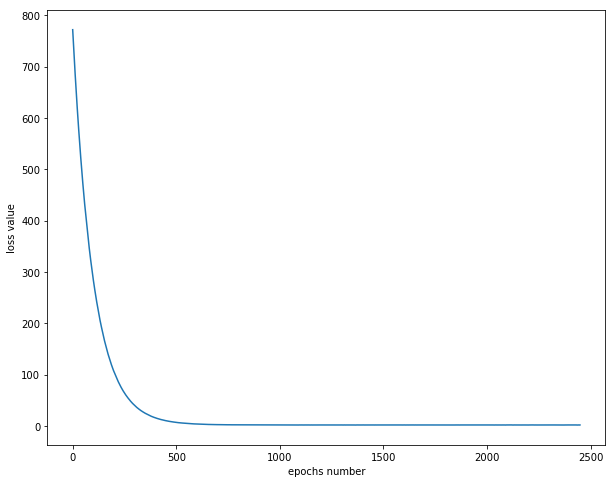


Valuation on test-set acc = 32.69%


In [7]:
plt.plot(loss_hist)
plt.xlabel('epochs number')
plt.ylabel('loss value')
plt.show()

scores_np = softmax_np(W, X_test, None, reg)
acc = np.mean(np.argmax(scores_np, axis=1) == y_test)
print('\nValuation on test-set acc = {:5.2f}%'.format(100 * acc))

### SGD with Tensorflow
We use the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer), moreover we redefine the variable to scale down to single precision

In [8]:
tf.reset_default_graph()

# create trainable variable
vW = tf.Variable(initW, dtype=tf.float32, name = 'W')

# create placeholder to feed input
vX = tf.placeholder(tf.float32, name = 'X')
vy = tf.placeholder(tf.int64, name = 'y')
vreg = tf.placeholder(tf.float32, name = 'reg')

# create scores/cost
scores_tf = tf.matmul(vX, vW)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=vy, logits=scores_tf)) \
                                                            + vreg * tf.nn.l2_loss(vW)
grad = tf.gradients(cost, vW)[0]

# define train op
train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)

# define correct-prediciont op to compute accuracy
correct_pred = tf.equal(tf.argmax(scores_tf, axis = 1), vy)
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

nb_iters = train_data.get_nb_iters(epochs)
loss_history = []    
opt_W = None
print_every = 100

with tf.Session() as sess:
    # init out variable
    sess.run(tf.global_variables_initializer())
    
    # reset seed for batch-data
    np.random.seed(2793)
    
    # training loop
    start = time.time()
    for i in range(1, nb_iters + 1):
        X_batch, y_batch = train_data.next_batch()
        loss, _ = sess.run([cost, train_op], feed_dict= {vX : X_batch, vy : y_batch, vreg : reg})

        loss_history.append(loss)
        # log current state        
        if (i % print_every == 0):                    
            print('Iter {:>10d}/{:<10d} loss {:10.4f}'.format(i, nb_iters, loss))


        epoch_end, epoch = train_data.is_epoch_end(i)
        if (epoch_end) or (i == 1):
            # validation it here
            if val_data is not None:
                X_val, y_val = val_data.next_batch()

                val_acc = sess.run(acc, feed_dict= { vX : X_val, vy : y_val, vreg : reg})

                print('\nEpoch {:>3d}/{:<3d} val_acc = {:5.2f}%'.format(epoch, epochs, 100 * val_acc))
        opt_W = sess.run(vW)

    print ('\nTrain time: {:<10.2f} seconds'.format(time.time() - start))


Epoch   0/10  val_acc = 11.20%
Iter        100/2450       loss   286.5407
Iter        200/2450       loss   106.0692

Epoch   1/10  val_acc = 21.70%
Iter        300/2450       loss    40.2307
Iter        400/2450       loss    16.0513

Epoch   2/10  val_acc = 31.70%
Iter        500/2450       loss     7.1443
Iter        600/2450       loss     3.9063
Iter        700/2450       loss     2.8100

Epoch   3/10  val_acc = 33.50%
Iter        800/2450       loss     2.3135
Iter        900/2450       loss     2.1872

Epoch   4/10  val_acc = 34.20%
Iter       1000/2450       loss     2.0387
Iter       1100/2450       loss     2.0602
Iter       1200/2450       loss     2.0797

Epoch   5/10  val_acc = 33.70%
Iter       1300/2450       loss     2.0849
Iter       1400/2450       loss     2.1100

Epoch   6/10  val_acc = 34.30%
Iter       1500/2450       loss     2.0791
Iter       1600/2450       loss     2.1064
Iter       1700/2450       loss     2.0572

Epoch   7/10  val_acc = 34.20%
Iter       18

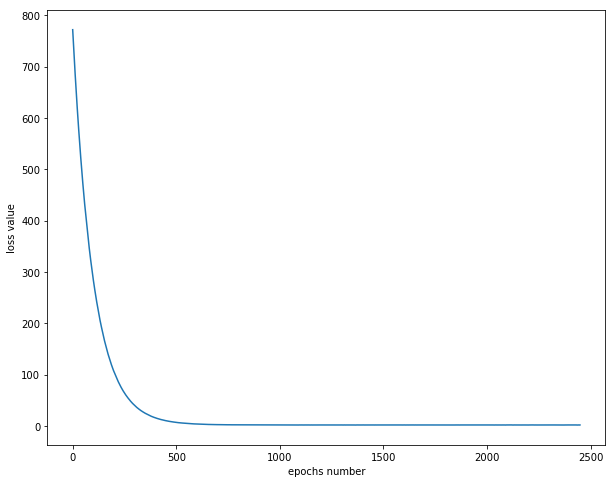


Valuation on test-set acc = 32.69%


In [9]:
plt.plot(loss_history)
plt.xlabel('epochs number')
plt.ylabel('loss value')
plt.show()

scores = softmax_np(W, X_test, None, reg)
acc = np.mean(np.argmax(scores, axis=1) == y_test)
print('\nValuation on test-set acc = {:5.2f}%'.format(100 * acc))

## Numpy vs TensorFlow
For Softmax, it's much easier to implement it in TensorFlow since we can use it out of the box. The both implementations give similar result. However, once again we see TensorFlow is 3 times slower than Numpy, we might need to investigate further.